In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt


In [4]:

test_df = pd.read_pickle("FY26.pkl")
train_df = pd.read_pickle("FY24FY25.pkl")



In [4]:
test_df.shape

(278942, 24)

In [5]:
train_df.shape

(2707209, 24)

In [6]:
pd.set_option("display.max_columns",None)
train_df.head()

,ANSR / Tech Revenue FYTD,AR Outstanding,Billed Expenses FYTD,Billed Fees FYTD,Billed Revenue Days,Charged Hours FYTD,Client,Client ID,EAF Reserve FYTD,ETD Total Collections,Engagement Partner,Engagement Sub Service Line,Expenses FYTD,FYTD Collections,FYTD Labor Costs,FYTD Unbilled Expenses,Location,MS,NUI ETD,Total Billed FYTD,Unbilled Revenue Days,Month,Week,Year
0,0.0,0.0,0.0,0.0,0.0,0.0,QUEST GLOBAL SERVICES PTE. LTD.,11421164,0.0,0.0,"Ghosh, Subh",Audit,0.0,0.0,0.0,0.0,Bangalore,TMT,0.0,0.0,0.0,03 Sep,10,FY24
1,0.0,0.0,0.0,0.0,0.0,0.0,Industrial Energy Limited,11881305,0.0,0.0,"Agarwal, Sanjay",Audit,0.0,0.0,0.0,0.0,East,IIC,0.0,0.0,0.0,03 Sep,10,FY24
2,0.0,0.0,0.0,0.0,0.0,0.0,Vini Cosmetics Private Limited,11453641,0.0,0.0,"Kalia, Chaitanya",CCaSS,0.0,0.0,0.0,0.0,Mumbai,IIC,0.0,0.0,0.0,03 Sep,10,FY24
3,0.0,0.0,0.0,0.0,0.0,0.0,UNIPHORE SOFTWARE SYSTEMS PRIVATE LIMITED,12239544,0.0,0.0,"Agrawal, Ayush",FAAS,0.0,0.0,0.0,0.0,Delhi,TMT,0.0,0.0,0.0,03 Sep,10,FY24
4,0.0,0.0,0.0,0.0,0.0,0.0,THE TATA POWER COMPANY LIMITED,11230405,0.0,0.0,"Kalia, Chaitanya",CCaSS,0.0,0.0,0.0,0.0,Mumbai,IIC,0.0,0.0,0.0,03 Sep,10,FY24


In [7]:
with open("xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Define features again
features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]

target = "ANSR / Tech Revenue FYTD"

# Ensure test_df only has the required features
test_df = test_df[features + [target]].copy()

# Encode categorical columns
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]

for col in cat_cols:
    le = LabelEncoder()
    test_df[col] = test_df[col].astype(str)
    test_df[col] = le.fit_transform(test_df[col])

# Remove NaNs from target
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]

# Predict
y_pred = loaded_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ FY26 Evaluation Results")
print(f"   RMSE: {rmse:,.2f}")
print(f"   R² Score: {r2:.4f}")
print(f"   Samples used: {len(X_test):,}")


✅ FY26 Evaluation Results
   RMSE: 355,818.96
   R² Score: 0.8795
   Samples used: 278,337


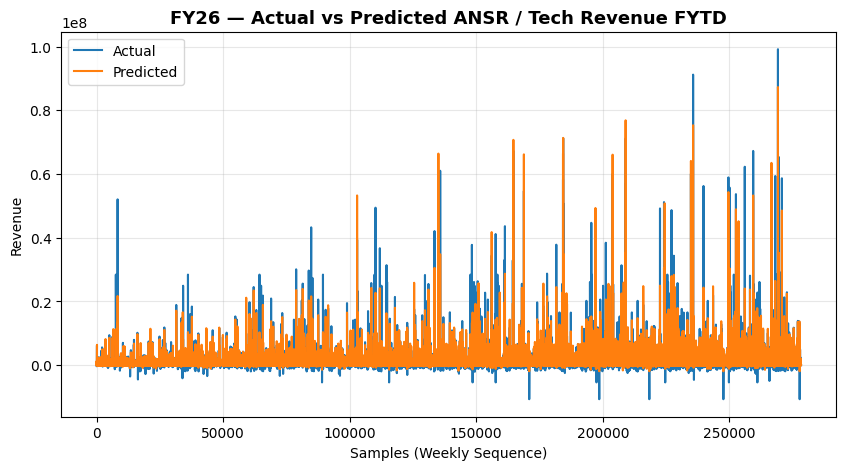

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="#1f77b4")
plt.plot(y_pred, label="Predicted", color="#ff7f0e")
plt.title("FY26 — Actual vs Predicted ANSR / Tech Revenue FYTD", fontsize=13, weight="bold")
plt.xlabel("Samples (Weekly Sequence)")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Take the latest FY26 data
latest_df = test_df.copy()

# Get the latest week available
latest_week = latest_df["Week"].max()
print(f"🗓️ Latest available week in FY26 data: {latest_week}")

# Predict for next 12 weeks
future_weeks = list(range(latest_week + 1, latest_week + 13))
print("📅 Future weeks to predict:", future_weeks)


🗓️ Latest available week in FY26 data: 13
📅 Future weeks to predict: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [11]:
# Take the most recent week's data as base
base_data = latest_df[latest_df["Week"] == latest_week].copy()

# Create a DataFrame for each future week
future_frames = []
for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)
print(f"✅ Future 12-week dataset created → {future_df.shape}")


✅ Future 12-week dataset created → (307800, 17)


In [12]:
# Features used for prediction
features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]

# Fill missing values
future_df = future_df.fillna(0)
X_future = future_df[features]


In [13]:
# Predict using your trained model
y_future_pred = loaded_model.predict(X_future)

# Add predictions back to the DataFrame
future_df["Predicted ANSR / Tech Revenue FYTD"] = y_future_pred

print("✅ Predictions for next 12 weeks completed!")
print(future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].head(20))


✅ Predictions for next 12 weeks completed!
    Week  Predicted ANSR / Tech Revenue FYTD
0     14                          461.337830
1     14                        71399.234375
2     14                        31730.738281
3     14                          461.337830
4     14                          371.178375
5     14                          503.001007
6     14                          593.160583
7     14                          503.001007
8     14                           85.529411
9     14                         -240.695084
10    14                        18364.867188
11    14                         -240.695084
12    14                          371.178375
13    14                          503.001007
14    14                          503.001007
15    14                          503.001007
16    14                          503.001007
17    14                          503.001007
18    14                          503.001007
19    14                          503.001007


c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


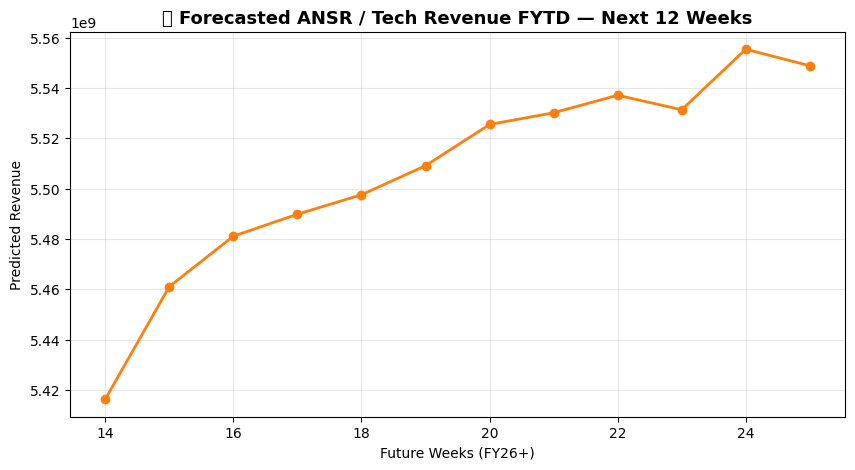

In [14]:
import matplotlib.pyplot as plt

# Aggregate weekly total
weekly_forecast = future_df.groupby("Week")["Predicted ANSR / Tech Revenue FYTD"].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(weekly_forecast["Week"], weekly_forecast["Predicted ANSR / Tech Revenue FYTD"], 
         marker='o', color='#ff7f0e', linewidth=2)
plt.title("📈 Forecasted ANSR / Tech Revenue FYTD — Next 12 Weeks", fontsize=13, weight="bold")
plt.xlabel("Future Weeks (FY26+)")
plt.ylabel("Predicted Revenue")
plt.grid(alpha=0.3)
plt.show()


In [15]:
test_df["Week"].unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

C:\Users\FV586VH\AppData\Local\Temp\ipykernel_12412\2084108740.py:75: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


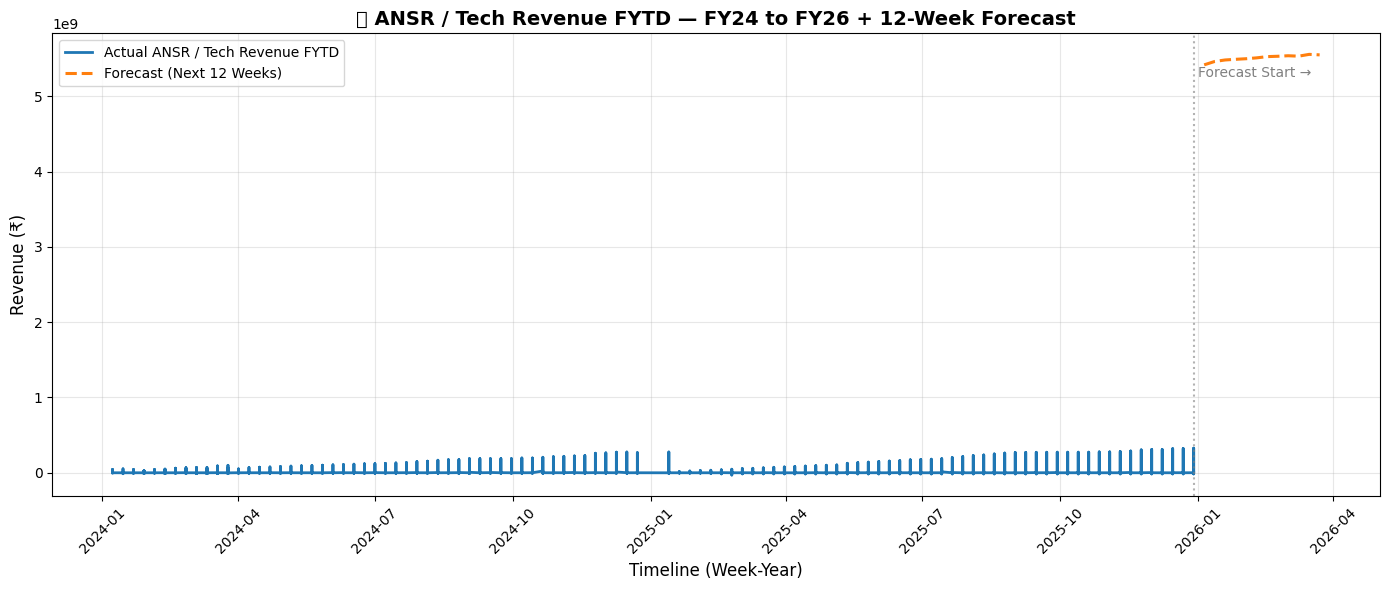

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🧩 Step 1: Combine all historical data (FY24 + FY25 + FY26)
historical = pd.concat([train_df, test_df], ignore_index=True)

# Keep only necessary columns
historical = historical[["Year", "Week", "ANSR / Tech Revenue FYTD"]].copy()
historical["DataType"] = "Actual"

# Convert Year (FY24 → 2024 etc.)
# Convert FY24 → 2024 safely, handle missing or malformed years
historical["Year_Num"] = (
    historical["Year"]
    .astype(str)
    .str.extract(r'(\d+)')[0]
    .fillna("24")      # default fallback year
    .astype(int)
    + 2000
)


# Create a proper Date column (Monday of each week)
historical["Date"] = pd.to_datetime(historical["Year_Num"].astype(str) + historical["Week"].astype(str) + '1', format='%Y%W%w', errors="coerce")

# 🧩 Step 2: Prepare Future Data (Next 12 Weeks Forecast)
future_df_plot = future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].copy()
future_df_plot = future_df_plot.groupby("Week", as_index=False).sum()
future_df_plot["Year"] = "FY26"
future_df_plot["DataType"] = "Predicted"

# Convert to date range just after the last week in historical FY26
last_date = historical["Date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=12, freq="W-MON")
future_df_plot["Date"] = future_dates

# Rename for consistency
future_df_plot.rename(columns={"Predicted ANSR / Tech Revenue FYTD": "ANSR / Tech Revenue FYTD"}, inplace=True)

# Combine everything
combined_df = pd.concat([historical, future_df_plot], ignore_index=True).sort_values("Date")

# 🧩 Step 3: Plotting
plt.figure(figsize=(14,6))

# Actual data — solid line
plt.plot(
    combined_df[combined_df["DataType"] == "Actual"]["Date"],
    combined_df[combined_df["DataType"] == "Actual"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual ANSR / Tech Revenue FYTD"
)

# Forecast data — dotted line
plt.plot(
    combined_df[combined_df["DataType"] == "Predicted"]["Date"],
    combined_df[combined_df["DataType"] == "Predicted"]["ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.2, linestyle="--", label="Forecast (Next 12 Weeks)"
)

# Optional cutoff marker
cutoff_date = historical["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_date + pd.Timedelta(days=3), plt.ylim()[1]*0.9, "Forecast Start →", color="gray", fontsize=10)

# 📅 Formatting
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 + 12-Week Forecast", fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Format x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


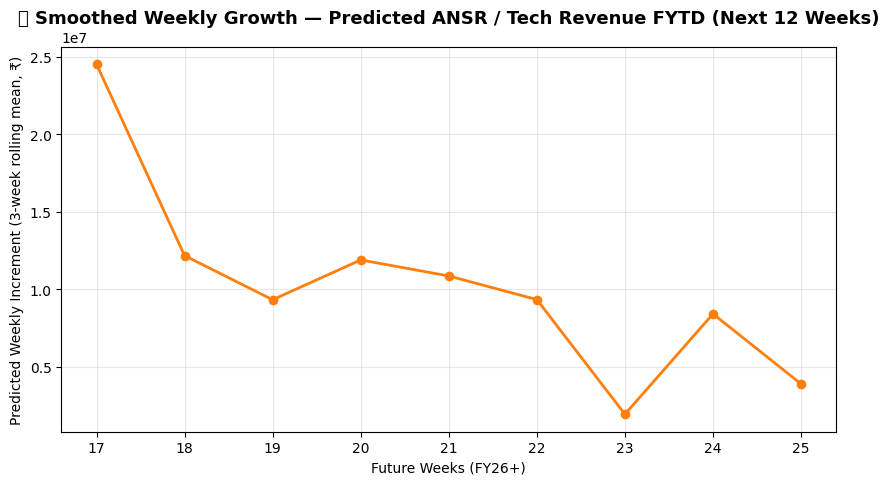

In [17]:
plt.figure(figsize=(10,5))
plt.plot(
    weekly_forecast["Week"], 
    weekly_forecast["Predicted ANSR / Tech Revenue FYTD"].diff().rolling(3).mean().clip(lower=0),
    marker='o', color='#ff7f0e', linewidth=2
)
plt.title("📈 Smoothed Weekly Growth — Predicted ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=13, weight="bold")
plt.xlabel("Future Weeks (FY26+)")
plt.ylabel("Predicted Weekly Increment (3-week rolling mean, ₹)")
plt.grid(alpha=0.3)
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_12412\4290217574.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


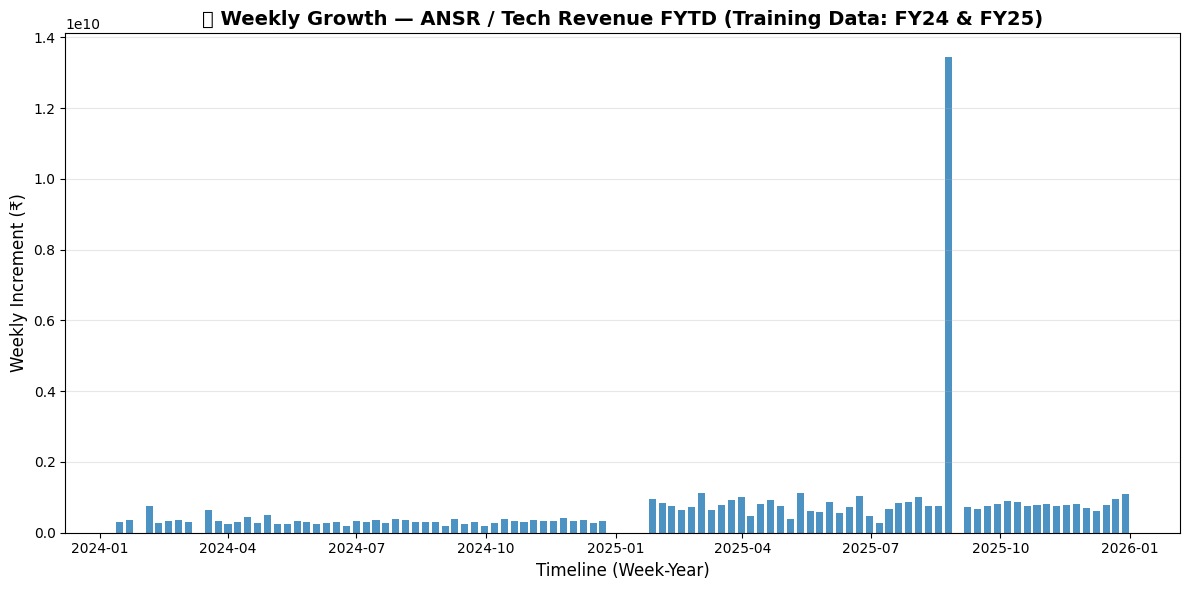

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# We'll use your training dataset
train_df = pd.read_pickle("FY24FY25.pkl")

# --- Step 1️⃣: Group by Week and Sum FYTD revenue
weekly_train = (
    train_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# --- Step 2️⃣: Compute Weekly Increment (difference between consecutive weeks)
weekly_train["ANSR_Weekly_Growth"] = (
    weekly_train.groupby("Year")["ANSR / Tech Revenue FYTD"]
    .diff()
    .clip(lower=0)
)

# --- Step 3️⃣: Convert Year to numeric (FY24 → 2024)
weekly_train["Year_Num"] = (
    weekly_train["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .fillna("24")
    .astype(int)
    + 2000
)

# --- Step 4️⃣: Create proper datetime (Monday of each week)
weekly_train["Date"] = pd.to_datetime(
    weekly_train["Year_Num"].astype(str) + weekly_train["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# --- Step 5️⃣: Plot bar chart for weekly growth
plt.figure(figsize=(12,6))
plt.bar(
    weekly_train["Date"],
    weekly_train["ANSR_Weekly_Growth"],
    color="#1f77b4",
    alpha=0.8,
    width=5,
)
plt.title("📊 Weekly Growth — ANSR / Tech Revenue FYTD (Training Data: FY24 & FY25)",
          fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Weekly Increment (₹)", fontsize=12)
plt.grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_12412\2335754500.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


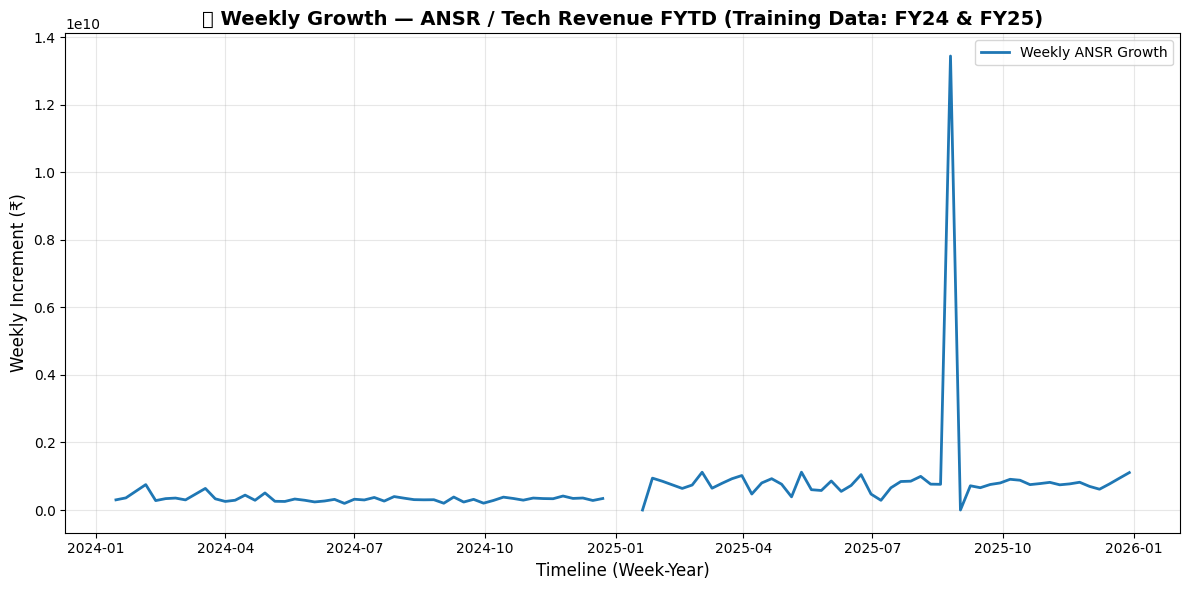

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load training data
train_df = pd.read_pickle("FY24FY25.pkl")

# 1️⃣ Aggregate FYTD revenue by Year–Week
weekly_train = (
    train_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# 2️⃣ Compute weekly incremental growth (ΔFYTD)
weekly_train["ANSR_Weekly_Growth"] = (
    weekly_train.groupby("Year")["ANSR / Tech Revenue FYTD"]
    .diff()
    .clip(lower=0)
)

# 3️⃣ Convert FY-year labels (FY24 → 2024 etc.)
weekly_train["Year_Num"] = (
    weekly_train["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .fillna("24")
    .astype(int)
    + 2000
)

# 4️⃣ Create a Date index (Monday of each week)
weekly_train["Date"] = pd.to_datetime(
    weekly_train["Year_Num"].astype(str) + weekly_train["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# 5️⃣ Plot: weekly growth as line
plt.figure(figsize=(12,6))
plt.plot(
    weekly_train["Date"],
    weekly_train["ANSR_Weekly_Growth"],
    color="#1f77b4",
    linewidth=2,
    label="Weekly ANSR Growth"
)

# Optional: smooth trend with rolling mean (4-week window)
# plt.plot(
#     weekly_train["Date"],
#     weekly_train["ANSR_Weekly_Growth"].rolling(4).mean(),
#     color="#ff7f0e",
#     linewidth=2.2,
#     linestyle="--",
#     label="4-Week Rolling Avg"
# )

# 🏷️ Chart formatting
plt.title("📈 Weekly Growth — ANSR / Tech Revenue FYTD (Training Data: FY24 & FY25)",
          fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Weekly Increment (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_12412\4068923942.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


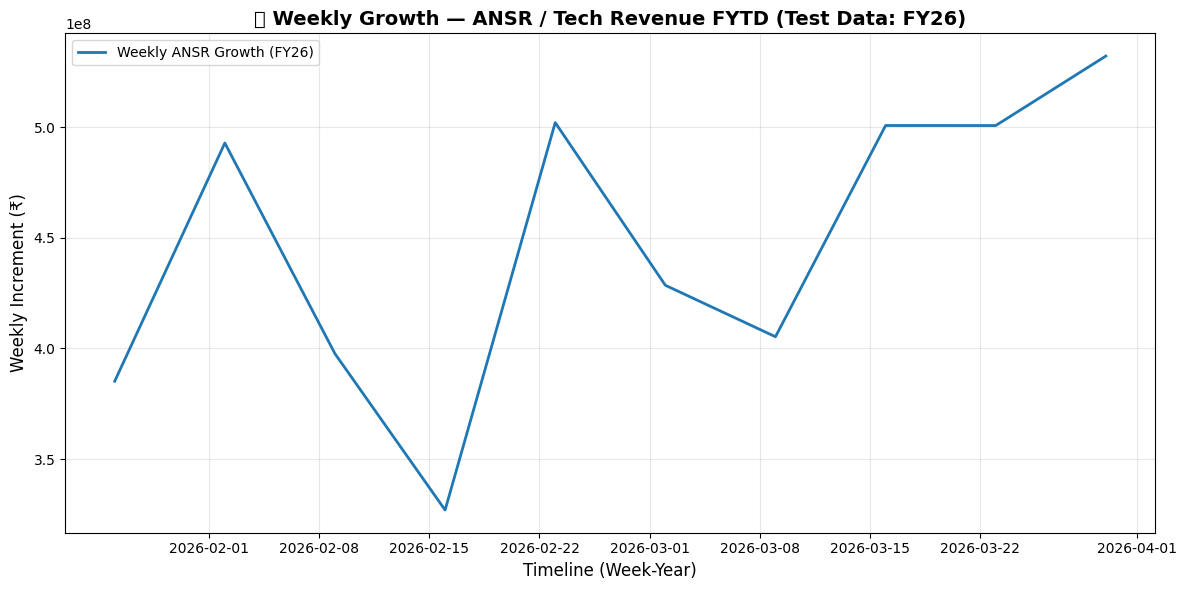

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Load FY26 test data
test_df = pd.read_pickle("FY26.pkl")

# 1️⃣ Aggregate ANSR revenue weekly
weekly_test = (
    test_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values("Week")
)

# 2️⃣ Calculate week-over-week revenue growth
weekly_test["ANSR_Weekly_Growth"] = weekly_test["ANSR / Tech Revenue FYTD"].diff().clip(lower=0)

# 3️⃣ Convert Year to numeric (FY26 → 2026)
weekly_test["Year_Num"] = (
    weekly_test["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .fillna("26")
    .astype(int)
    + 2000
)

# 4️⃣ Create datetime column (Monday of each week)
weekly_test["Date"] = pd.to_datetime(
    weekly_test["Year_Num"].astype(str) + weekly_test["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# 5️⃣ Plot line chart — weekly growth
plt.figure(figsize=(12,6))
plt.plot(
    weekly_test["Date"],
    weekly_test["ANSR_Weekly_Growth"],
    color="#1f77b4",
    linewidth=2,
    label="Weekly ANSR Growth (FY26)"
)

# Optional: add 4-week rolling mean for smoother trend
# plt.plot(
#     weekly_test["Date"],
#     weekly_test["ANSR_Weekly_Growth"].rolling(4).mean(),
#     color="#ff7f0e",
#     linewidth=2.2,
#     linestyle="--",
#     label="4-Week Rolling Avg"
# )

# 🏷️ Chart formatting
plt.title("📈 Weekly Growth — ANSR / Tech Revenue FYTD (Test Data: FY26)",
          fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Weekly Increment (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_12412\3459304041.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


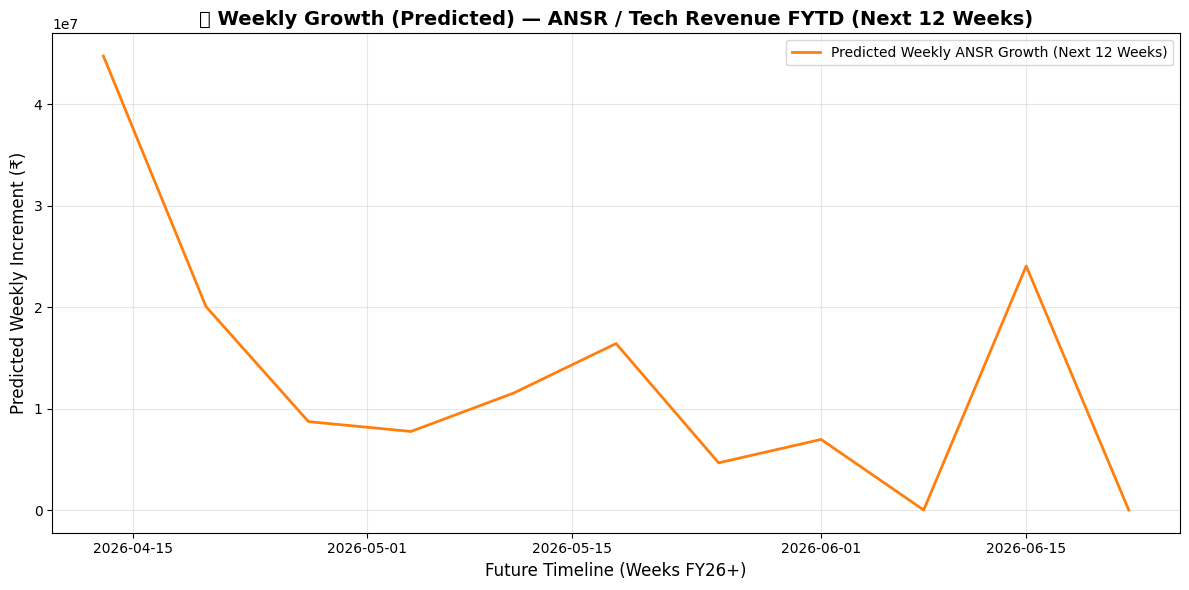

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your forecast DataFrame is available as `future_df`
# and contains columns: ['Week', 'Predicted ANSR / Tech Revenue FYTD']

# 1️⃣ Aggregate weekly predicted revenue
weekly_forecast = (
    future_df.groupby("Week")["Predicted ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values("Week")
)

# 2️⃣ Compute weekly incremental growth (week-over-week difference)
weekly_forecast["Predicted_Weekly_Growth"] = weekly_forecast["Predicted ANSR / Tech Revenue FYTD"].diff().clip(lower=0)

# 3️⃣ Add a dummy fiscal year (FY26+) for timeline continuity
latest_year = 2026
weekly_forecast["Year_Num"] = latest_year

# 4️⃣ Convert to proper datetime (Monday of each week)
weekly_forecast["Date"] = pd.to_datetime(
    weekly_forecast["Year_Num"].astype(str) + weekly_forecast["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# 5️⃣ Plot weekly growth (predicted)
plt.figure(figsize=(12,6))

plt.plot(
    weekly_forecast["Date"],
    weekly_forecast["Predicted_Weekly_Growth"],
    color="#ff7f0e",
    linewidth=2,
    label="Predicted Weekly ANSR Growth (Next 12 Weeks)"
)

# Optional: rolling average for smoother pattern
# plt.plot(
#     weekly_forecast["Date"],
#     weekly_forecast["Predicted_Weekly_Growth"].rolling(3).mean(),
#     color="#2ca02c",
#     linestyle="--",
#     linewidth=2.2,
#     label="3-Week Rolling Avg"
# )

# 🏷️ Chart formatting
plt.title("📈 Weekly Growth (Predicted) — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
          fontsize=14, weight="bold")
plt.xlabel("Future Timeline (Weeks FY26+)", fontsize=12)
plt.ylabel("Predicted Weekly Increment (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [1]:
train_df

NameError: name 'train_df' is not defined

🔹 Top Positive Correlations:
ANSR / Tech Revenue FYTD    1.000000
Total Billed FYTD           0.872716
Billed Fees FYTD            0.872467
FYTD Collections            0.830976
FYTD Labor Costs            0.814243
Charged Hours FYTD          0.805747
ETD Total Collections       0.499153
AR Outstanding              0.396587
Billed Expenses FYTD        0.369916
Expenses FYTD               0.267235
Name: ANSR / Tech Revenue FYTD, dtype: float64

🔹 Top Negative Correlations:
ETD Total Collections     0.499153
AR Outstanding            0.396587
Billed Expenses FYTD      0.369916
Expenses FYTD             0.267235
NUI ETD                   0.170758
FYTD Unbilled Expenses    0.129716
Week                      0.058204
Billed Revenue Days       0.050412
Unbilled Revenue Days     0.018827
EAF Reserve FYTD         -0.358145
Name: ANSR / Tech Revenue FYTD, dtype: float64


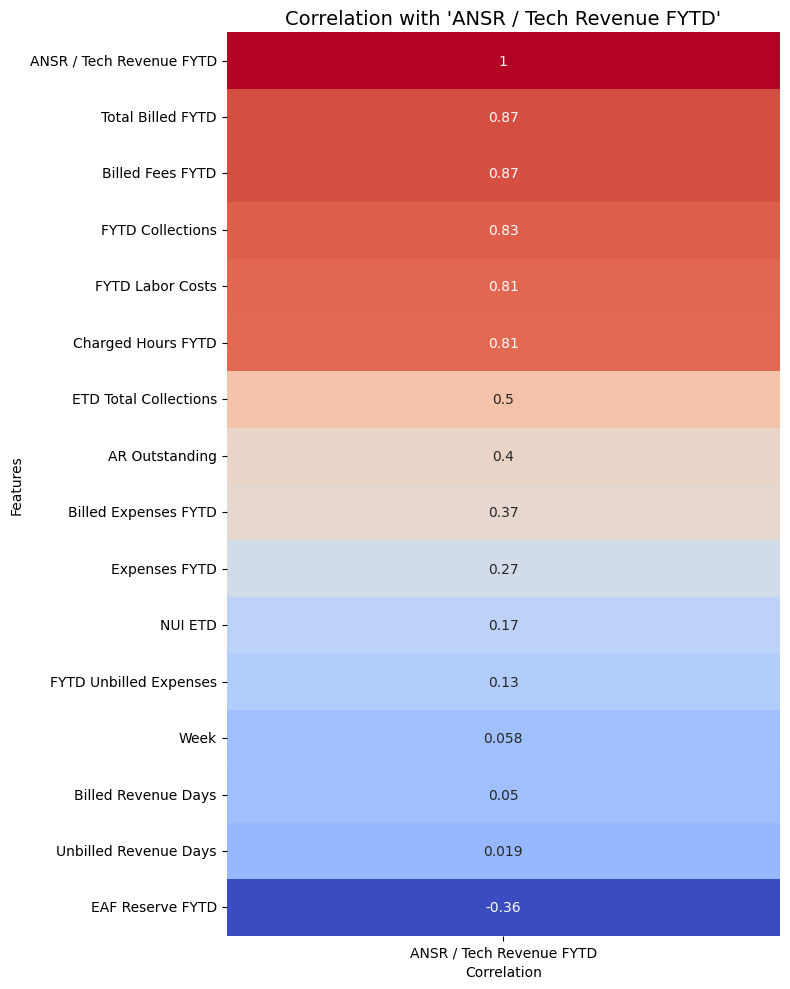

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Target column name ---
target = "ANSR / Tech Revenue FYTD"

# --- 1️⃣ Select only numeric columns ---
numeric_df = train_df.select_dtypes(include=['number'])

# --- 2️⃣ Compute correlation with target ---
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

# --- 3️⃣ Display top correlated features ---
print("🔹 Top Positive Correlations:")
print(corr_with_target.head(10))
print("\n🔹 Top Negative Correlations:")
print(corr_with_target.tail(10))

# --- 4️⃣ Plot correlation heatmap focused on target ---
plt.figure(figsize=(8, 10))
sns.heatmap(
    corr_with_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    cbar=False
)
plt.title("Correlation with 'ANSR / Tech Revenue FYTD'", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# --- 5️⃣ (Optional) Full correlation heatmap for all numeric features ---
# plt.figure(figsize=(15, 12))
# sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
# plt.title("Full Feature Correlation Heatmap", fontsize=14)
# plt.show()


✅ Correlation Matrix (numeric columns only):
                          ANSR / Tech Revenue FYTD  AR Outstanding  \
ANSR / Tech Revenue FYTD                  1.000000        0.396587   
AR Outstanding                            0.396587        1.000000   
Billed Expenses FYTD                      0.369916        0.132555   
Billed Fees FYTD                          0.872467        0.491254   
Billed Revenue Days                       0.050412        0.288874   
Charged Hours FYTD                        0.805747        0.321203   
EAF Reserve FYTD                         -0.358145       -0.138617   
ETD Total Collections                     0.499153        0.191043   
Expenses FYTD                             0.267235        0.136146   
FYTD Collections                          0.830976        0.222871   
FYTD Labor Costs                          0.814243        0.324837   
FYTD Unbilled Expenses                    0.129716        0.088174   
NUI ETD                                   0.1

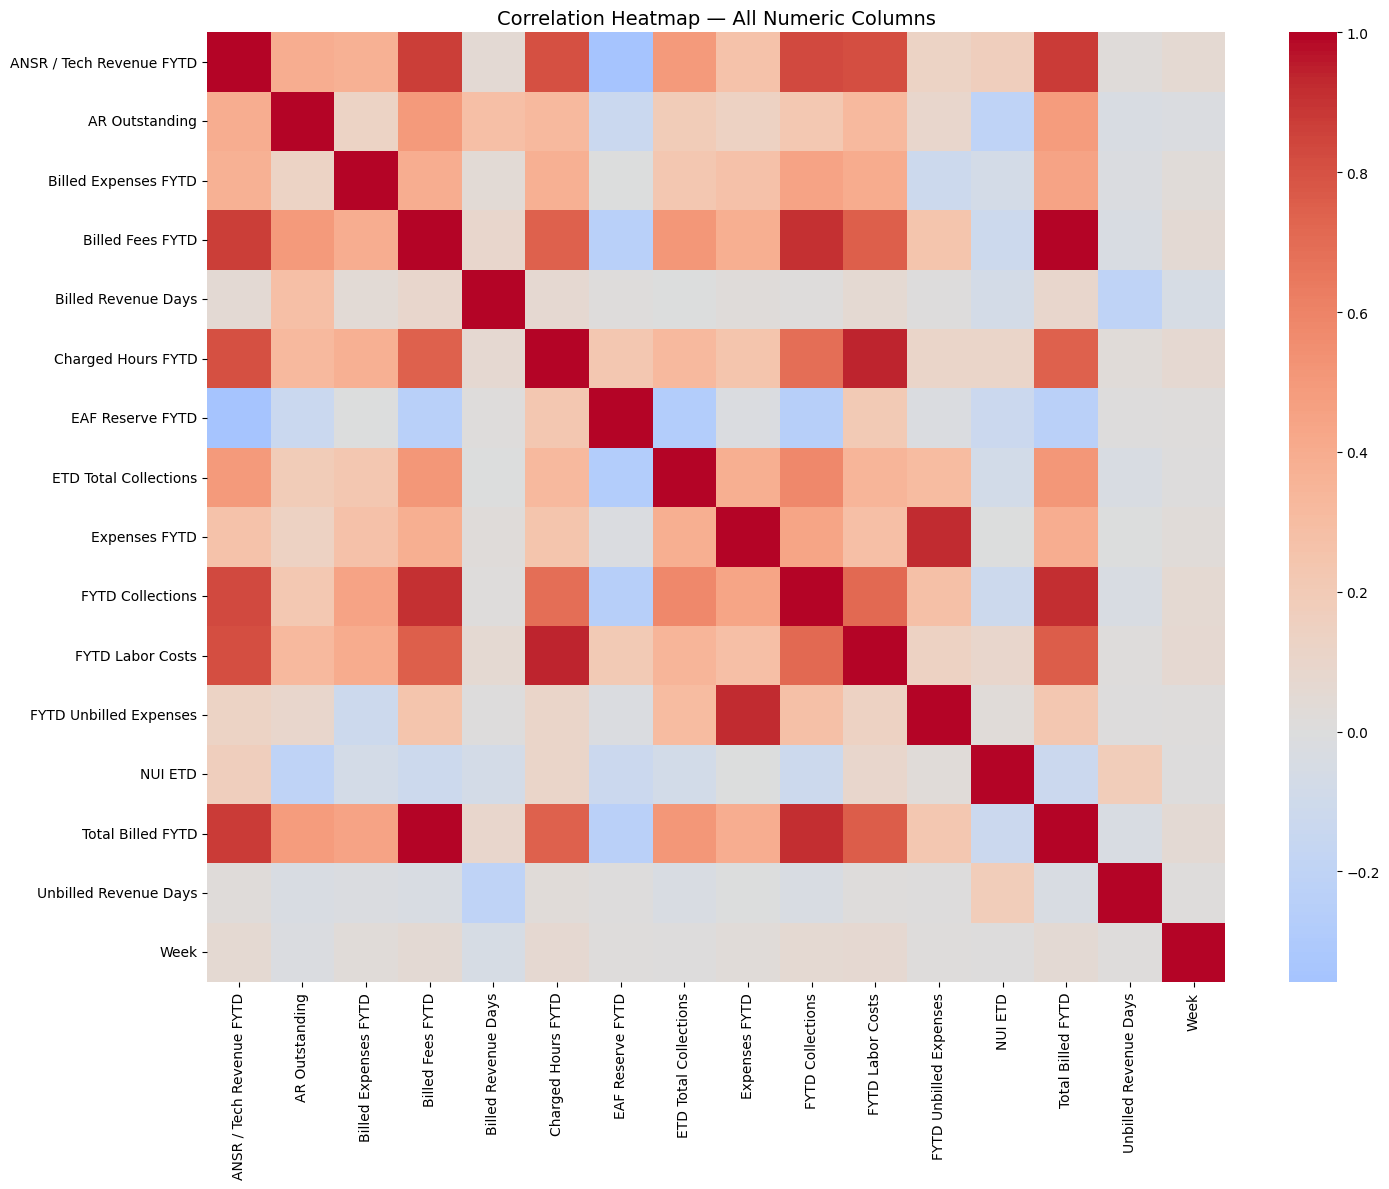

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Select only numeric columns ---
numeric_df = train_df.select_dtypes(include=['number'])

# --- 2️⃣ Compute correlation matrix ---
corr_matrix = numeric_df.corr()

# --- 3️⃣ Display correlation matrix ---
print("✅ Correlation Matrix (numeric columns only):")
print(corr_matrix)

# --- 4️⃣ Plot full correlation heatmap ---
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix,
    annot=False,       # change to True if you want numbers on each cell
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Heatmap — All Numeric Columns", fontsize=14)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
df_full = pd.read_csv("merged_training_data_common_cols.csv")

KeyboardInterrupt: 

🔹 Total categorical columns: 53
['Account', 'Account ID', 'Account Name', 'Cap Market/SSC/Others', 'Cap Market/SSC/Secondment/Others', 'Client', 'Client DUNS', 'Client ID', 'Client Name', 'Client Sector', 'Client Sub Sector', 'EM', 'EM GPN', 'EP', 'EP GPN', 'Engagement', 'Engagement ID', 'Engagement Manager', 'Engagement Manager GUI', 'Engagement Manager Province', 'Engagement Manager Service Line', 'Engagement Manager Sub Service Line', 'Engagement Partner', 'Engagement Partner GUI', 'Engagement Partner Province', 'Engagement Partner Service Line', 'Engagement Province', 'Engagement Service', 'Engagement Status', 'Engagement Sub Service Line', 'File_Name', 'Last Expenses Charged Date', 'Last Invoice Issued Date', 'Last Time Charged Date', 'Location', 'MS', 'Month', 'Month_Serialized', 'Opportunity', 'Opportunity ID', 'Opportunity Partner', 'Partner BU', 'Release Date', 'SEC Indicator', 'Same FY?', 'Service Offering', 'Standard/Lean Eng Indicator', 'Sub_Folder_1', 'Sub_Folder_2', 'Tran

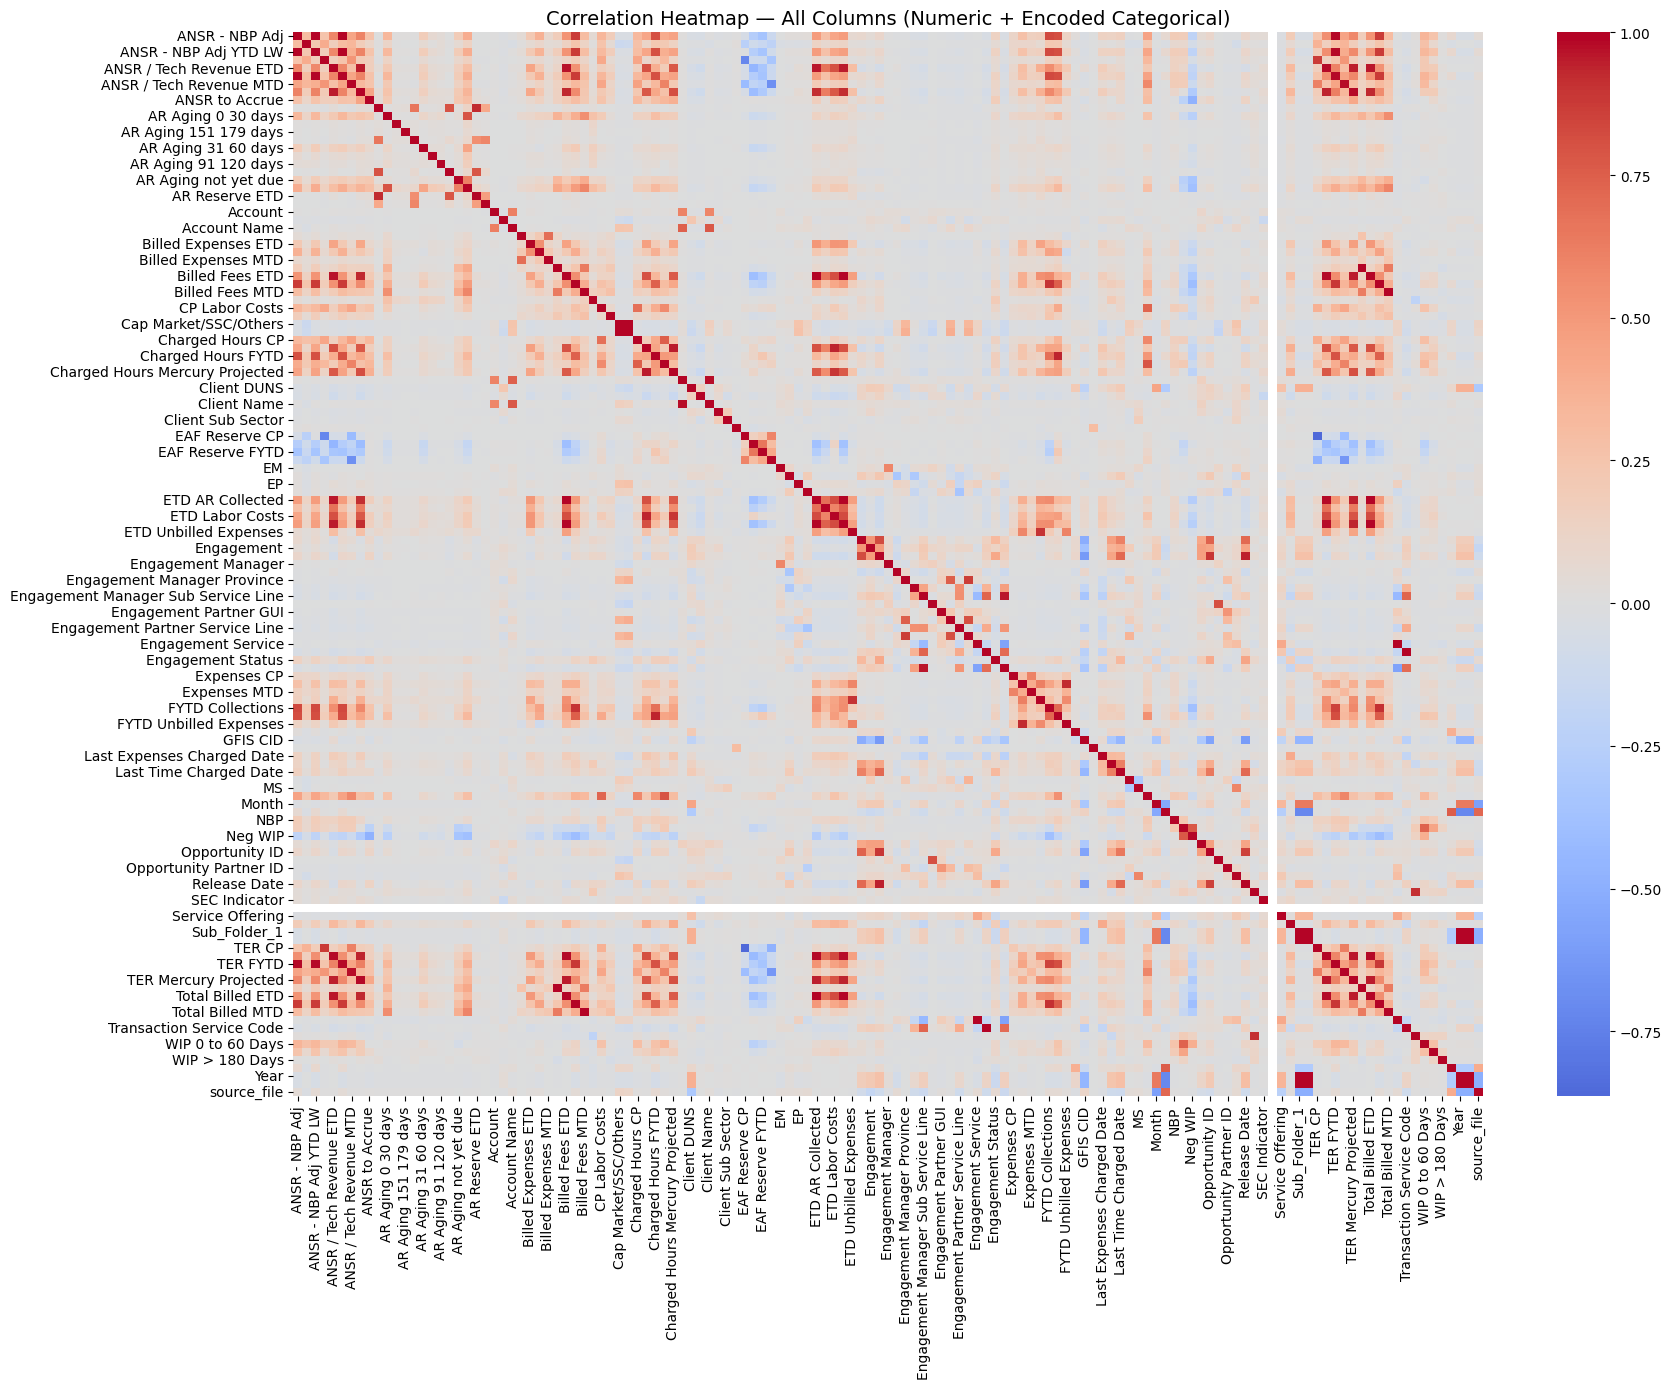

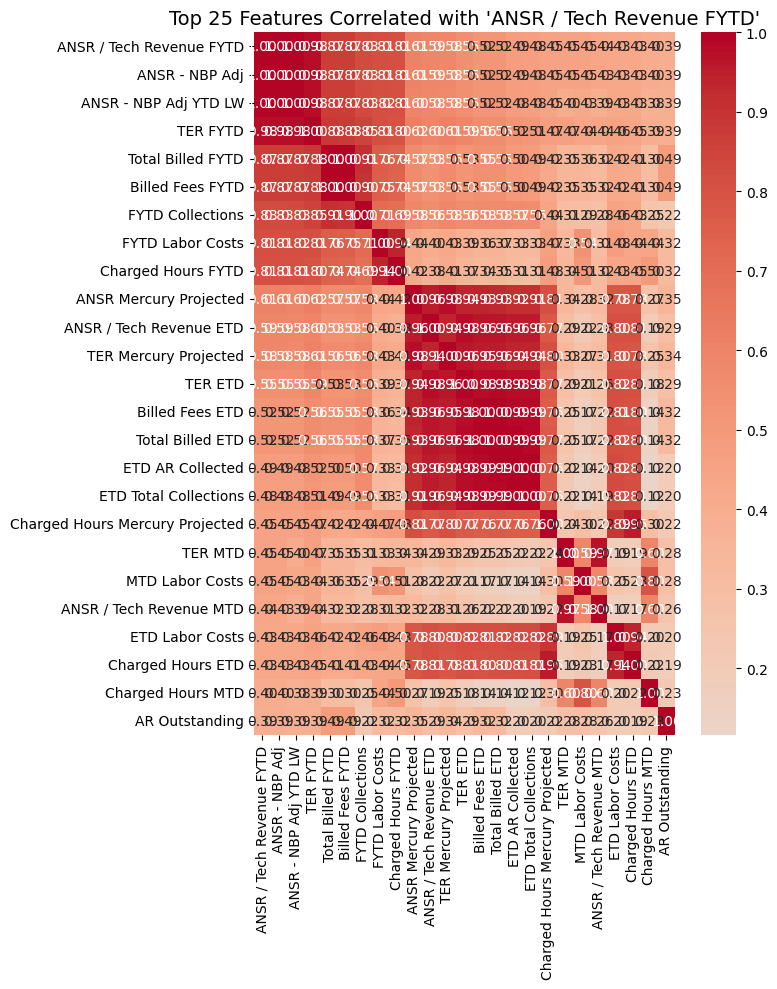

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Copy to avoid modifying original ---
df_encoded = df_full.copy()

# --- 2️⃣ Identify categorical columns ---
cat_cols = df_encoded.select_dtypes(include=['object']).columns
print(f"🔹 Total categorical columns: {len(cat_cols)}")
print(list(cat_cols))

# --- 3️⃣ Encode categorical columns using category codes ---
# (each unique text value gets a numeric code)
for col in cat_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# --- 4️⃣ Compute correlation matrix ---
corr_matrix = df_encoded.corr()

# --- 5️⃣ Display correlation matrix info ---
print("✅ Correlation matrix shape:", corr_matrix.shape)

# --- 6️⃣ Plot full heatmap ---
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False
)
plt.title("Correlation Heatmap — All Columns (Numeric + Encoded Categorical)", fontsize=14)
plt.tight_layout()
plt.show()

# --- 7️⃣ (Optional) Focused view: top 25 most correlated with target ---
target = "ANSR / Tech Revenue FYTD"   # 👈 your target column
if target in corr_matrix.columns:
    top_corr = corr_matrix[target].abs().sort_values(ascending=False).head(25)
    plt.figure(figsize=(8, 10))
    sns.heatmap(
        df_encoded[top_corr.index].corr(),
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f"
    )
    plt.title(f"Top 25 Features Correlated with '{target}'", fontsize=14)
    plt.tight_layout()
    plt.show()


🔹 Total categorical columns: 8
🔹 Top Positive Correlations:
ANSR / Tech Revenue FYTD    1.000000
Total Billed FYTD           0.872716
Billed Fees FYTD            0.872467
FYTD Collections            0.830976
FYTD Labor Costs            0.814243
Charged Hours FYTD          0.805747
ETD Total Collections       0.499153
AR Outstanding              0.396587
Billed Expenses FYTD        0.369916
Expenses FYTD               0.267235
NUI ETD                     0.170758
FYTD Unbilled Expenses      0.129716
Week                        0.058204
Billed Revenue Days         0.050412
Unbilled Revenue Days       0.018827
Name: ANSR / Tech Revenue FYTD, dtype: float64

🔹 Top Negative Correlations:
Expenses FYTD                  0.267235
NUI ETD                        0.170758
FYTD Unbilled Expenses         0.129716
Week                           0.058204
Billed Revenue Days            0.050412
Unbilled Revenue Days          0.018827
Client                         0.010269
MS                          

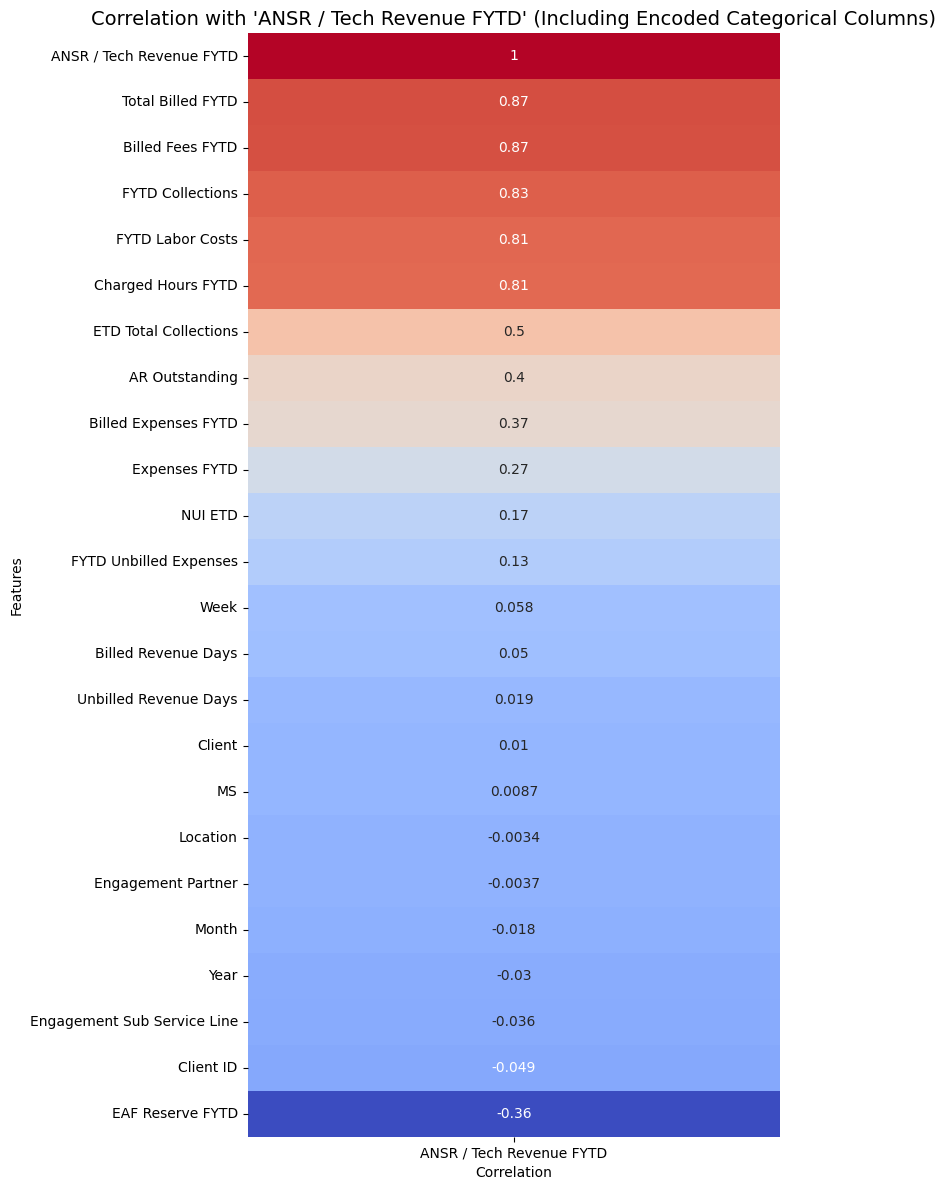

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Target column name ---
target = "ANSR / Tech Revenue FYTD"

# --- 1️⃣ Make a copy to avoid modifying the original ---
df_encoded = train_df.copy()

# --- 2️⃣ Identify categorical columns ---
cat_cols = df_encoded.select_dtypes(include=['object']).columns
print(f"🔹 Total categorical columns: {len(cat_cols)}")

# --- 3️⃣ Encode categorical columns as numeric codes ---
for col in cat_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# --- 4️⃣ Select all numeric columns (now includes encoded categoricals) ---
numeric_df = df_encoded.select_dtypes(include=['number'])

# --- 5️⃣ Compute correlation with target ---
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

# --- 6️⃣ Display top correlated features ---
print("🔹 Top Positive Correlations:")
print(corr_with_target.head(15))
print("\n🔹 Top Negative Correlations:")
print(corr_with_target.tail(15))

# --- 7️⃣ Plot correlation heatmap focused on target ---
plt.figure(figsize=(8, 12))
sns.heatmap(
    corr_with_target.to_frame(),
    annot=True,
    cmap="coolwarm",
    cbar=False
)
plt.title("Correlation with 'ANSR / Tech Revenue FYTD' (Including Encoded Categorical Columns)", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# --- 8️⃣ (Optional) Full correlation heatmap for all features ---
# plt.figure(figsize=(16, 12))
# sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
# plt.title("Full Feature Correlation Heatmap (Numeric + Encoded Categorical)", fontsize=14)
# plt.show()


✅ XGBoost Model — FY26 Evaluation Results
   RMSE     : 532,866.52
   R² Score : 0.7292
   Samples  : 278,942


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_6012\929031243.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


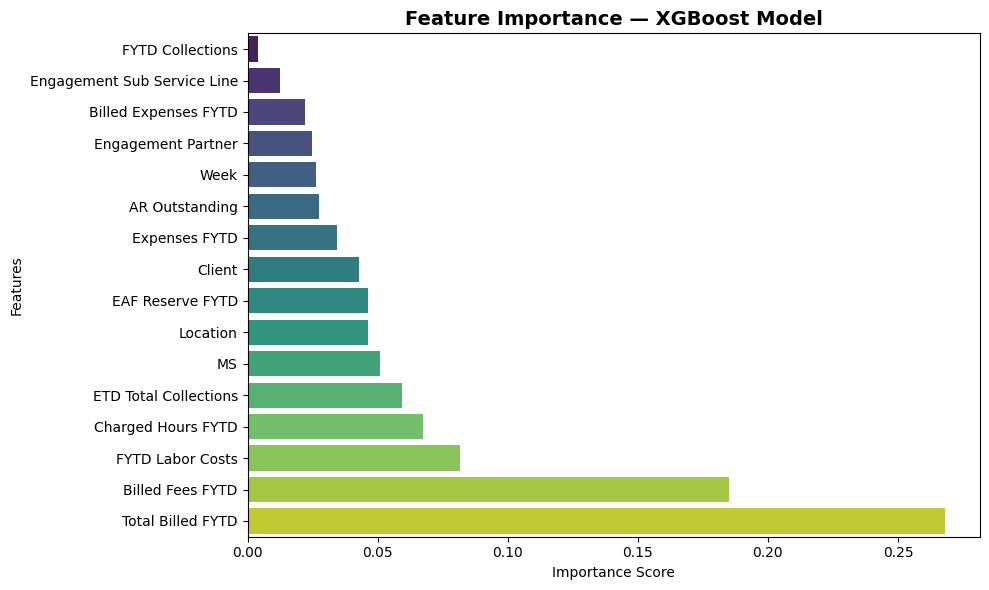

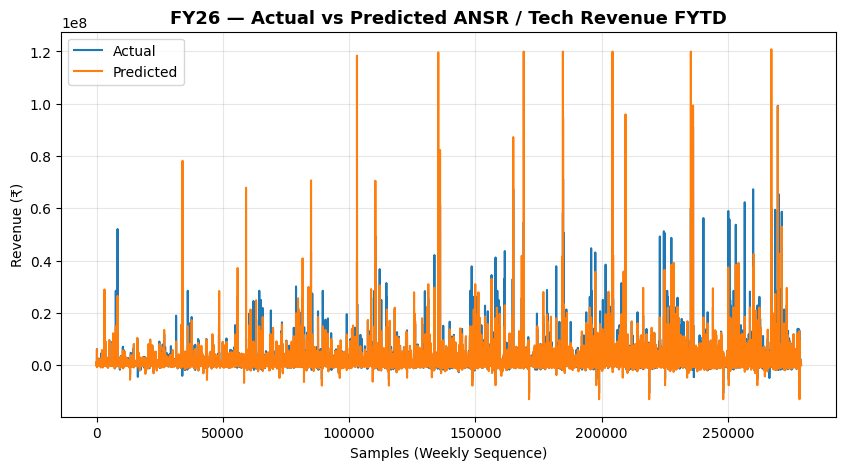

C:\Users\FV586VH\AppData\Local\Temp\ipykernel_6012\929031243.py:143: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


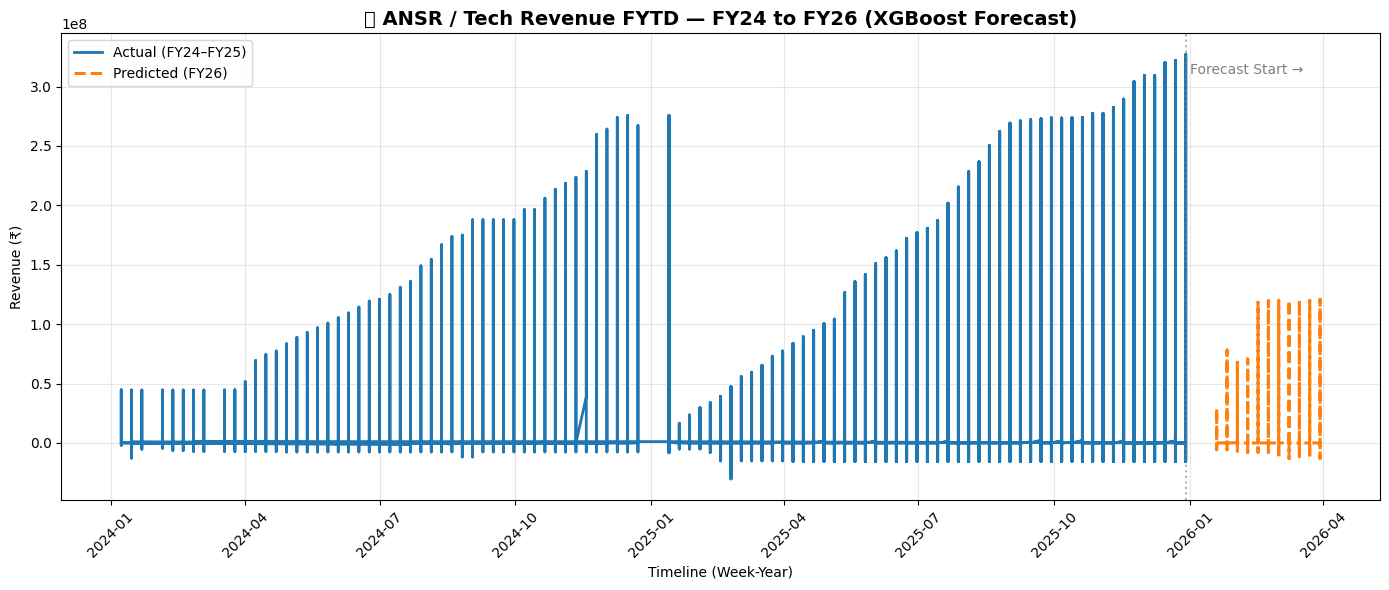


💾 Model saved as 'xgb_model_trained.pkl'

📊 Model Summary:
      Metric      Value
        RMSE 532,866.52
    R² Score     0.7292
Test Samples    278,942


In [ ]:
# =====================================================
# 📊 XGBoost Model — ANSR / Tech Revenue FYTD Forecast
# Train: FY24–FY25   |   Test: FY26
# Handles unseen categories & missing values
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle

# === 1️⃣ Load Data ===
train_df = pd.read_pickle("FY24FY25.pkl")
test_df = pd.read_pickle("FY26.pkl")

# === 2️⃣ Define Target and Features ===
target = "ANSR / Tech Revenue FYTD"
features = [
    "Total Billed FYTD", "Billed Fees FYTD", "FYTD Collections",
    "FYTD Labor Costs", "Charged Hours FYTD", "ETD Total Collections",
    "AR Outstanding", "Billed Expenses FYTD", "Expenses FYTD", "EAF Reserve FYTD",
    "MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner", "Week"
]

# === 3️⃣ Encode Categorical Columns (Safely for unseen test values) ===
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    
    # Safe mapping for test data (unknown → -1)
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    test_df[col] = test_df[col].astype(str).map(mapping)
    test_df[col] = test_df[col].fillna(-1).astype(int)

# === 4️⃣ Handle missing values for numeric columns ===
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# === 5️⃣ Prepare Training and Testing Sets ===
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Remove any rows with missing target values
mask = ~y_train.isna()
X_train, y_train = X_train[mask], y_train[mask]

mask = ~y_test.isna()
X_test, y_test = X_test[mask], y_test[mask]

# === 6️⃣ Train XGBoost Model ===
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)

# === 7️⃣ Predict and Evaluate ===
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Model — FY26 Evaluation Results")
print(f"   RMSE     : {rmse:,.2f}")
print(f"   R² Score : {r2:.4f}")
print(f"   Samples  : {len(X_test):,}")

# === 8️⃣ Feature Importance Plot ===
plt.figure(figsize=(10,6))
importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=True)
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance — XGBoost Model", fontsize=14, weight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# === 9️⃣ Actual vs Predicted Plot ===
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="#1f77b4")
plt.plot(y_pred, label="Predicted", color="#ff7f0e")
plt.title("FY26 — Actual vs Predicted ANSR / Tech Revenue FYTD", fontsize=13, weight="bold")
plt.xlabel("Samples (Weekly Sequence)")
plt.ylabel("Revenue (₹)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 🔟 Combine Historical (FY24–FY25) + FY26 Predicted for Timeline ===
historical = train_df[["Year", "Week", target]].copy()
historical["DataType"] = "Actual"

predicted = test_df[["Year", "Week"]].copy()
predicted[target] = y_pred
predicted["DataType"] = "Predicted"

combined_df = pd.concat([historical, predicted], ignore_index=True)

# Convert Year to numeric and create a timeline
combined_df["Year_Num"] = (
    combined_df["Year"].astype(str).str.extract(r"(\d+)")[0].fillna("24").astype(int) + 2000
)
combined_df["Date"] = pd.to_datetime(
    combined_df["Year_Num"].astype(str) + combined_df["Week"].astype(str) + "1",
    format="%Y%W%w", errors="coerce"
)

# === 11️⃣ Timeline Plot (FY24–FY26) ===
plt.figure(figsize=(14,6))
plt.plot(
    combined_df[combined_df["DataType"]=="Actual"]["Date"],
    combined_df[combined_df["DataType"]=="Actual"][target],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY25)"
)
plt.plot(
    combined_df[combined_df["DataType"]=="Predicted"]["Date"],
    combined_df[combined_df["DataType"]=="Predicted"][target],
    color="#ff7f0e", linewidth=2.2, linestyle="--", label="Predicted (FY26)"
)

cutoff_date = combined_df[combined_df["DataType"]=="Actual"]["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_date + pd.Timedelta(days=3),
         plt.ylim()[1]*0.9, "Forecast Start →",
         color="gray", fontsize=10)

plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)")
plt.ylabel("Revenue (₹)")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 12️⃣ Save Model ===
with open("xgb_model_trained.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("\n💾 Model saved as 'xgb_model_trained.pkl'")

# === 13️⃣ Summary Report ===
summary = pd.DataFrame({
    "Metric": ["RMSE", "R² Score", "Test Samples"],
    "Value": [f"{rmse:,.2f}", f"{r2:.4f}", f"{len(X_test):,}"]
})
print("\n📊 Model Summary:")
print(summary.to_string(index=False))


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# --- Clean Week & Year columns ---
combined_df = combined_df.copy()
combined_df = combined_df.dropna(subset=["Week", "Year", "ANSR / Tech Revenue FYTD"])  # drop empty rows

# Ensure Week is integer-like and Year is string
combined_df["Week"] = combined_df["Week"].astype(int)
combined_df["Year"] = combined_df["Year"].astype(str)

# --- Create readable Week_Label (safe for all values) ---
combined_df["Week_Label"] = combined_df["Week"].apply(lambda w: f"W{int(w):02d}") + " " + combined_df["Year"]

# --- Sort ---
combined_df = combined_df.sort_values(["Year", "Week"]).reset_index(drop=True)

# === Plot ===
plt.figure(figsize=(14,6))

# Actual (FY24–FY25)
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Actual", "Week_Label"],
    combined_df.loc[combined_df["DataType"] == "Actual", "ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2.2, marker='o', markersize=3, label="Actual (FY24–FY25)"
)

# Predicted (FY26)
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Predicted", "Week_Label"],
    combined_df.loc[combined_df["DataType"] == "Predicted", "ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.4, linestyle="--", marker='o', markersize=3, label="Forecast (FY26)"
)

# --- FY Start Lines ---
fy_starts = combined_df.groupby("Year")["Week_Label"].first().reset_index()
for _, row in fy_starts.iterrows():
    plt.axvline(x=row["Week_Label"], color="gray", linestyle=":", alpha=0.6)
    plt.text(row["Week_Label"], plt.ylim()[1]*0.95, f"{row['Year']} Start →",
             color="gray", fontsize=9, ha="left")

# --- Formatting ---
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Week–Fiscal Year", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Limit tick clutter
tick_positions = range(0, len(combined_df), 4)
plt.xticks(tick_positions, combined_df["Week_Label"].iloc[tick_positions], rotation=45, fontsize=9)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


In [ ]:
# === 9️⃣ Actual vs Predicted Plot (with Week Numbers on X-axis) ===
plt.figure(figsize=(10,5))

weeks = test_df["Week"].values  # Use static week numbers from test data

plt.plot(weeks, y_test.values, label="Actual", color="#1f77b4", linewidth=2)
plt.plot(weeks, y_pred, label="Predicted", color="#ff7f0e", linewidth=2, linestyle="--")

plt.title("FY26 — Actual vs Predicted ANSR / Tech Revenue FYTD", fontsize=13, weight="bold")
plt.xlabel("Week Number (FY26)")
plt.ylabel("Revenue (₹)")
plt.legend()
plt.grid(alpha=0.3)

# Show only every 2nd or 5th week for clarity depending on data size
step = 2 if len(weeks) <= 20 else 5
plt.xticks(weeks[::step], rotation=45)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# =====================================================
# 📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)
# Standalone Plot Code
# =====================================================

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# 🧩 Ensure combined_df exists with at least these columns:
# ['Year', 'Week', 'Date', 'ANSR / Tech Revenue FYTD', 'DataType']

# Sort chronologically
combined_df = combined_df.sort_values(["Year", "Week"]).reset_index(drop=True)

# --- 1️⃣ Create Week–FY Year labels for X-axis ---
combined_df["Week_Label"] = (
    "W" + combined_df["Week"].astype(int).astype(str).str.zfill(2)
    + " " + combined_df["Year"].astype(str)
)

# --- 2️⃣ Plot ---
plt.figure(figsize=(14,6))

# Actual Data
plt.plot(
    combined_df.loc[combined_df["DataType"]=="Actual", "Date"],
    combined_df.loc[combined_df["DataType"]=="Actual", "ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY25)"
)

# Predicted Data
plt.plot(
    combined_df.loc[combined_df["DataType"]=="Predicted", "Date"],
    combined_df.loc[combined_df["DataType"]=="Predicted", "ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.2, linestyle="--", label="Predicted (FY26)"
)

# --- 3️⃣ Forecast Start Marker ---
cutoff_date = combined_df.loc[combined_df["DataType"]=="Actual", "Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(
    cutoff_date + pd.Timedelta(days=3),
    plt.ylim()[1]*0.9,
    "Forecast Start →",
    color="gray", fontsize=10
)

# --- 4️⃣ Customize X-axis labels: Every 2 Weeks ---
tick_positions = combined_df["Date"].iloc[::2]
tick_labels = combined_df["Week_Label"].iloc[::2]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=9)

# --- 5️⃣ Formatting ---
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Week–Fiscal Year", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Display full numeric values on y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.tight_layout()
plt.show()


NameError: name 'combined_df' is not defined

In [ ]:
print("gi")

C:\Users\FV586VH\AppData\Local\Temp\ipykernel_23080\3133182690.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


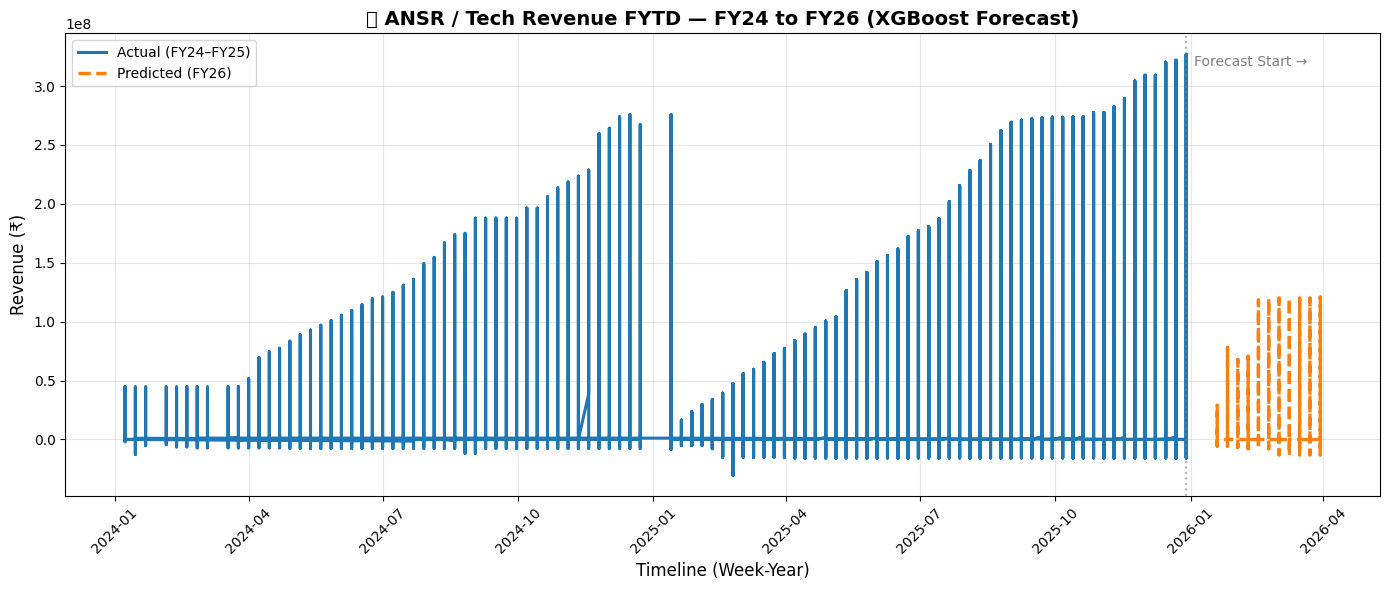

In [ ]:
# =====================================================
# 📈 Line Graph — ANSR / Tech Revenue FYTD
# (Actual: FY24–FY25 | Predicted: FY26)
# =====================================================

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `combined_df` already exists from previous code
# and contains columns: ['Date', 'ANSR / Tech Revenue FYTD', 'DataType']

plt.figure(figsize=(14,6))

# Plot Actual (FY24–FY25)
plt.plot(
    combined_df[combined_df["DataType"] == "Actual"]["Date"],
    combined_df[combined_df["DataType"] == "Actual"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2.2, label="Actual (FY24–FY25)"
)

# Plot Predicted (FY26)
plt.plot(
    combined_df[combined_df["DataType"] == "Predicted"]["Date"],
    combined_df[combined_df["DataType"] == "Predicted"]["ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.4, linestyle="--", label="Predicted (FY26)"
)

# Add Forecast start marker
cutoff_date = combined_df[combined_df["DataType"] == "Actual"]["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_date + pd.Timedelta(days=5),
         plt.ylim()[1]*0.92,
         "Forecast Start →",
         color="gray", fontsize=10)

# Chart formatting
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# =====================================================
# 📈 Line Graph — ANSR / Tech Revenue FYTD
# (Actual: FY24–FY25 | Predicted: FY26)
# with X-axis as "Week–FY Year"
# =====================================================

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `combined_df` already exists and includes:
# ['Year', 'Week', 'Date', 'ANSR / Tech Revenue FYTD', 'DataType']

plt.figure(figsize=(14,6))

# Plot Actual (FY24–FY25)
plt.plot(
    combined_df[combined_df["DataType"] == "Actual"]["Date"],
    combined_df[combined_df["DataType"] == "Actual"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2.2, label="Actual (FY24–FY25)"
)

# Plot Predicted (FY26)
plt.plot(
    combined_df[combined_df["DataType"] == "Predicted"]["Date"],
    combined_df[combined_df["DataType"] == "Predicted"]["ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.4, linestyle="--", label="Predicted (FY26)"
)

# Add Forecast start marker
cutoff_date = combined_df[combined_df["DataType"] == "Actual"]["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_date + pd.Timedelta(days=5),
         plt.ylim()[1]*0.92,
         "Forecast Start →",
         color="gray", fontsize=10)

# === Custom X-axis Labels: Week–FYYear ===
tick_positions = combined_df["Date"].iloc[::4]  # Show every 4th week for clarity
tick_labels = [
    f"W{int(week)} {year}"
    for week, year in zip(
        combined_df["Week"].iloc[::4],
        combined_df["Year"].iloc[::4]
    )
]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=9)

# Chart formatting
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Week–Fiscal Year", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002D4510ED080> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002D453435E40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

C:\Users\FV586VH\AppData\Local\Temp\ipykernel_35728\1721459611.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FV586VH\AppData\Local\Temp\ipykernel_35728\1721459611.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


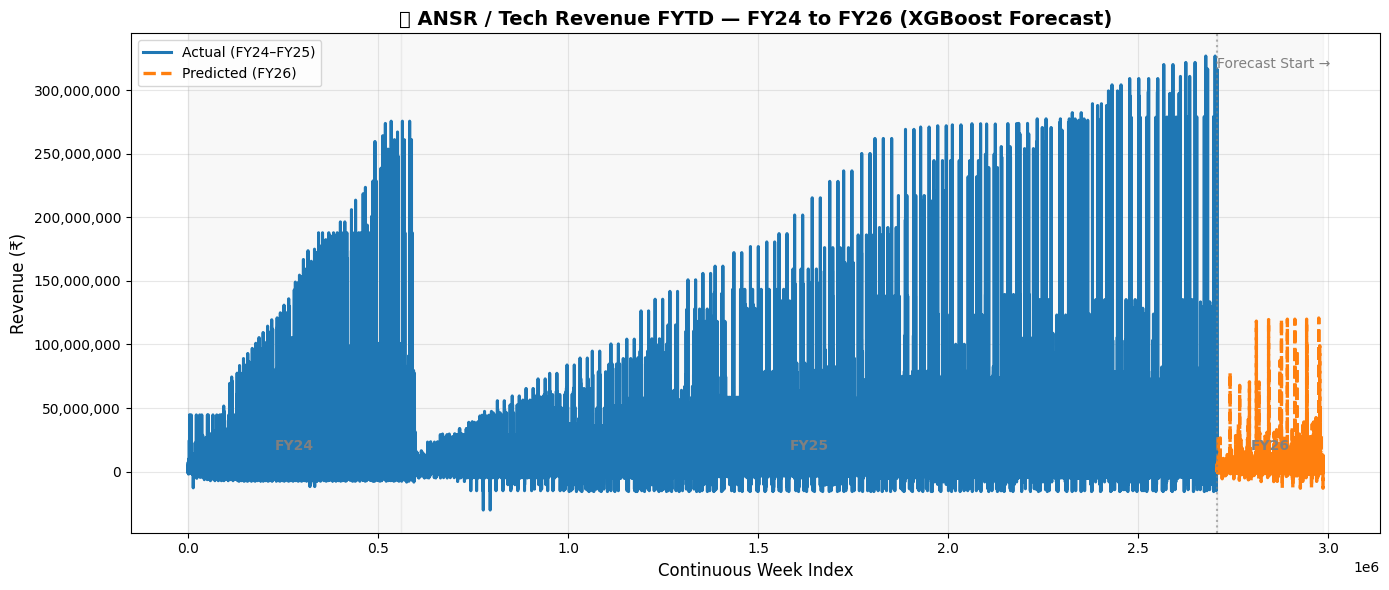

C:\Users\FV586VH\AppData\Local\Temp\ipykernel_23080\1721459611.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FV586VH\AppData\Local\Temp\ipykernel_23080\1721459611.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


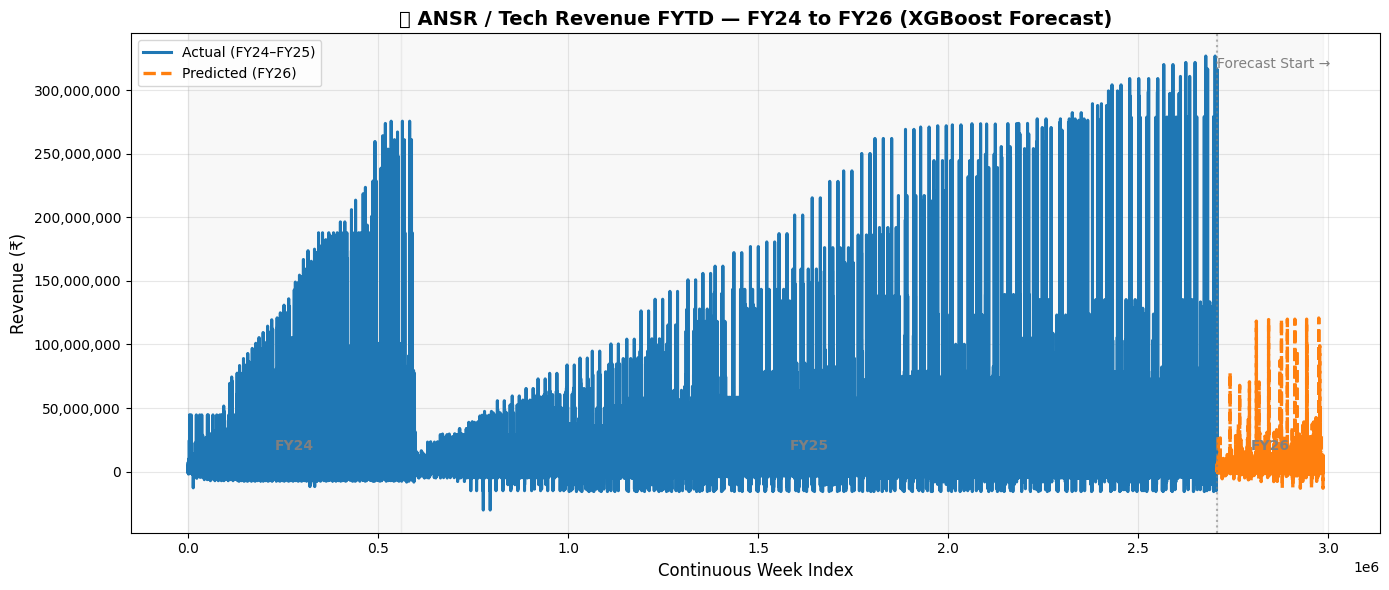

In [ ]:
# =====================================================
# 📈 Continuous Week-Line Graph — ANSR / Tech Revenue FYTD
# (FY24 → FY25 → FY26) — No Overlap
# =====================================================

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Ensure 'combined_df' exists and has: ['Year', 'Week', 'ANSR / Tech Revenue FYTD', 'DataType']

# --- Create a continuous week index ---
combined_df = combined_df.sort_values(["Year", "Week"]).reset_index(drop=True)
combined_df["Week_Index"] = range(1, len(combined_df) + 1)

# --- Map fiscal years to continuous index ranges ---
fy_ranges = (
    combined_df.groupby("Year")["Week_Index"]
    .agg(["min", "max"])
    .reset_index()
)

# === Plot Setup ===
plt.figure(figsize=(14,6))

# Actual (FY24–FY25)
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Actual", "Week_Index"],
    combined_df.loc[combined_df["DataType"] == "Actual", "ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2.2, label="Actual (FY24–FY25)"
)

# Predicted (FY26)
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Predicted", "Week_Index"],
    combined_df.loc[combined_df["DataType"] == "Predicted", "ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.4, linestyle="--", label="Predicted (FY26)"
)

# === Add FY Background Bands ===
for _, row in fy_ranges.iterrows():
    plt.axvspan(row["min"], row["max"], alpha=0.05, color="gray")
    mid = (row["min"] + row["max"]) / 2
    plt.text(mid, plt.ylim()[1]*0.05, row["Year"], ha="center", fontsize=10, color="gray", weight="bold")

# === Forecast Start Marker ===
cutoff_idx = combined_df.loc[combined_df["DataType"] == "Actual", "Week_Index"].max()
plt.axvline(x=cutoff_idx, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_idx + 2,
         plt.ylim()[1]*0.92,
         "Forecast Start →",
         color="gray", fontsize=10)

# === Labels and Formatting ===
plt.title("📈 ANSR / Tech Revenue FYTD — FY24 to FY26 (XGBoost Forecast)", fontsize=14, weight="bold")
plt.xlabel("Continuous Week Index", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Full numbers on Y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Cleaner layout
plt.tight_layout()
plt.show()


In [ ]:
# =====================================================
# 📈 XGBoost Forecast — ANSR / Tech Revenue FYTD
# (FY24 → FY25 → FY26)
# Matching Baseline Forecast Label Style
# =====================================================

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Assuming `combined_df` already exists with columns:
# ['Year', 'Week', 'Date', 'ANSR / Tech Revenue FYTD', 'DataType']

# === 1️⃣ Sort & Create Continuous Week Labels (W01 FY24 → W52 FY26) ===
combined_df = combined_df.sort_values(["Year", "Week"]).reset_index(drop=True)
combined_df["Week_Label"] = combined_df["Week"].apply(lambda w: f"W{int(w):02d}") + " " + combined_df["Year"]

# === 2️⃣ Plot Setup ===
plt.figure(figsize=(14,6))

# --- Actual (FY24–FY25) ---
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Actual", "Week_Label"],
    combined_df.loc[combined_df["DataType"] == "Actual", "ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2.2, marker='o', markersize=3,
    label="Actual (FY24–FY25)"
)

# --- Predicted (FY26) ---
plt.plot(
    combined_df.loc[combined_df["DataType"] == "Predicted", "Week_Label"],
    combined_df.loc[combined_df["DataType"] == "Predicted", "ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linewidth=2.4, linestyle="--", marker='o', markersize=3,
    label="Forecast (FY26)"
)

# === 3️⃣ Add FY Reference Lines ===
fy_starts = (
    combined_df.groupby("Year")["Week_Label"]
    .first()
    .reset_index()
)
for _, row in fy_starts.iterrows():
    plt.axvline(x=row["Week_Label"], color="gray", linestyle=":", alpha=0.6)
    plt.text(
        row["Week_Label"], plt.ylim()[1]*0.95,
        f"{row['Year']} Start →",
        color="gray", fontsize=9, ha="left"
    )

# === 4️⃣ Chart Formatting ===
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24–FY26)", fontsize=14, weight="bold")
plt.xlabel("Week Number (FY24–FY26)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Show full y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Rotate and limit x-axis ticks for clarity
tick_positions = range(0, len(combined_df), 4)  # every 4th week
plt.xticks(tick_positions, combined_df["Week_Label"].iloc[tick_positions], rotation=45, fontsize=9)

plt.tight_layout()
plt.show()



NameError: name 'combined_df' is not defined